## Import libraries

In [1]:
from pyomo.environ import (Constraint,
                           Var,
                           ConcreteModel,
                           Expression,
                           Param,
                           Objective,
                           SolverFactory,
                           TransformationFactory,
                           value)

from pyomo.network import Arc, SequentialDecomposition

from idaes.core.util.initialization import propagate_state

# Import plotting functions
import matplotlib.pyplot as plt

# Import numpy library 
import numpy as np

# Import the main FlowsheetBlock from IDAES. The flowsheet block will contain the unit model
from idaes.core import FlowsheetBlock

import idaes.logger as idaeslog
from pyomo.opt import TerminationCondition, SolverStatus

# Import the degrees_of_freedom function from the idaes.core.util.model_statistics package
# DOF = Number of Model Variables - Number of Model Constraints
from idaes.core.util.model_statistics import degrees_of_freedom

# Import the Generic Parameter Block
from idaes.generic_models.properties.core.generic.generic_property import (
        GenericParameterBlock)

# Import unit models from the model library
from idaes.generic_models.unit_models import Flash

# Import R32, R125, IL info file
from HFCS_emimTF2N_PR import configuration

## Create Model

In [2]:
# Create the ConcreteModel and the FlowsheetBlock, and attach the flowsheet block to it.
m = ConcreteModel()

m.fs = FlowsheetBlock(default={"dynamic": False}) 

# Add properties parameter blocks to the flowsheet with specifications
m.fs.props = GenericParameterBlock(default=configuration)

In [3]:
m.fs.F101 = Flash(default={"property_package": m.fs.props,
                               "has_heat_transfer": True,
                               "has_pressure_change": True})

# Call the degrees_of_freedom function, get intitial DOF
DOF_initial = degrees_of_freedom(m)
print("The initial DOF is {0}".format(DOF_initial))

The initial DOF is 8


In [4]:
## Update conditions to reduce DOF

# Fix Heater H101 inlet conditions
m.fs.F101.inlet.mole_frac_comp[0, "R32"].fix(0.5)
m.fs.F101.inlet.mole_frac_comp[0, "R125"].fix(0.5)
m.fs.F101.inlet.mole_frac_comp[0, "emimTf2N"].fix(0.001)

m.fs.F101.inlet.flow_mol[0].fix(1)
m.fs.F101.inlet.temperature.fix(320)
m.fs.F101.inlet.pressure.fix(200000)

# Fix F101 Flash outlet conditions
m.fs.F101.vap_outlet.temperature.fix(320)
m.fs.F101.deltaP.fix(0)

DOF_final = degrees_of_freedom(m)
print("The final DOF is {0}".format(DOF_final))

The final DOF is 0


In [5]:
solver = SolverFactory('ipopt')
solver.options = {'tol': 1e-6}

## Calculate flash data

In [6]:
# Set pressures to loop over
P = [200000,300000,400000,500000,600000,700000,800000,900000,1000000]

# Set fraction of feed compositions of HFCs to loop over
HFC_feed_frac = [0.001,0.4,0.72,0.91,0.99]

# Make outlet arrays
IL_x = np.zeros((len(P),len(HFC_feed_frac)))
IL_y = np.zeros((len(P),len(HFC_feed_frac)))
R32_x = np.zeros((len(P),len(HFC_feed_frac)))
R32_y = np.zeros((len(P),len(HFC_feed_frac)))
R125_x = np.zeros((len(P),len(HFC_feed_frac)))
R125_y = np.zeros((len(P),len(HFC_feed_frac))) 

for i in range(len(P)):
    
    # Fix pressure
    m.fs.F101.inlet.pressure.fix(P[i])
    
    for j in range(len(HFC_feed_frac)):
        
        # Fix inlet mole fractions
        fract = 1 - HFC_feed_frac[j] 
        m.fs.F101.inlet.mole_frac_comp[0, "R32"].fix(0.3*HFC_feed_frac[j])
        m.fs.F101.inlet.mole_frac_comp[0, "R125"].fix(0.3*fract)
        m.fs.F101.inlet.mole_frac_comp[0, "emimTf2N"].fix(0.7)   

        m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)              

        # solve the model
        status = solver.solve(m, tee = False)
        # model.display()
        
        # If solution is optimal store the concentration, and calculated temperatures in the created arrays
        if (status.solver.status == SolverStatus.ok) and (status.solver.termination_condition == TerminationCondition.optimal):

            IL_x[i,j] = value(m.fs.F101.liq_outlet.mole_frac_comp[0, "emimTf2N"])
            IL_y[i,j] = value(m.fs.F101.vap_outlet.mole_frac_comp[0, "emimTf2N"])
            R32_x[i,j] = value(m.fs.F101.liq_outlet.mole_frac_comp[0, "R32"]) 
            R32_y[i,j] = value(m.fs.F101.vap_outlet.mole_frac_comp[0, "R32"])
            R125_x[i,j] = value(m.fs.F101.liq_outlet.mole_frac_comp[0, "R125"])
            R125_y[i,j] = value(m.fs.F101.vap_outlet.mole_frac_comp[0, "R125"])

            #Change this to feasible
            print("Running pressure:",P[i],"and HFC feed fraction",HFC_feed_frac[j])
#             print(value(m.fs.F101.liq_outlet.flow_mol[0]))
#             print(value(m.fs.F101.vap_outlet.flow_mol[0]))
        else:
            print('Infeasible.')

    

Running pressure: 200000 and HFC feed fraction 0.001
Running pressure: 200000 and HFC feed fraction 0.4
Running pressure: 200000 and HFC feed fraction 0.72
Running pressure: 200000 and HFC feed fraction 0.91
Running pressure: 200000 and HFC feed fraction 0.99
Running pressure: 300000 and HFC feed fraction 0.001
Running pressure: 300000 and HFC feed fraction 0.4
Running pressure: 300000 and HFC feed fraction 0.72
Running pressure: 300000 and HFC feed fraction 0.91
Running pressure: 300000 and HFC feed fraction 0.99
Running pressure: 400000 and HFC feed fraction 0.001
Running pressure: 400000 and HFC feed fraction 0.4
Running pressure: 400000 and HFC feed fraction 0.72
Running pressure: 400000 and HFC feed fraction 0.91
Running pressure: 400000 and HFC feed fraction 0.99
Running pressure: 500000 and HFC feed fraction 0.001
Running pressure: 500000 and HFC feed fraction 0.4
Running pressure: 500000 and HFC feed fraction 0.72
Running pressure: 500000 and HFC feed fraction 0.91
Running pres

In [7]:
print("IL_x =", IL_x)
print("IL_y =", IL_y)
print("R32_x =", R32_x)
print("R32_y =", R32_y)
print("R125_x =", R125_x)
print("R125_y =", R125_y)

IL_x = [[0.93483379 0.91742611 0.90239042 0.89287236 0.88870426]
 [0.90286216 0.87913256 0.85793088 0.84398104 0.83768983]
 [0.87126535 0.84262669 0.81623465 0.79811681 0.78962551]
 [0.84001673 0.80774692 0.77717554 0.7552177  0.74440157]
 [0.80908757 0.77433154 0.74060311 0.71522862 0.70191192]
 [0.77844658 0.74222174 0.70634135 0.70000003 0.70000002]
 [0.7480592  0.71126401 0.70000002 0.70000001 0.70000001]
 [0.71788685 0.70000004 0.70000001 0.7        0.70000001]
 [0.70000009 0.70000001 0.7        0.7        0.70000001]]
IL_y = [[1.e-08 1.e-08 1.e-08 1.e-08 1.e-08]
 [1.e-08 1.e-08 1.e-08 1.e-08 1.e-08]
 [1.e-08 1.e-08 1.e-08 1.e-08 1.e-08]
 [1.e-08 1.e-08 1.e-08 1.e-08 1.e-08]
 [1.e-08 1.e-08 1.e-08 1.e-08 1.e-08]
 [1.e-08 1.e-08 1.e-08 1.e-08 1.e-08]
 [1.e-08 1.e-08 1.e-08 1.e-08 1.e-08]
 [1.e-08 1.e-08 1.e-08 1.e-08 1.e-08]
 [1.e-08 1.e-08 1.e-08 1.e-08 1.e-08]]
R32_x = [[1.02583704e-04 4.22496807e-02 7.82063905e-02 1.00756800e-01
  1.10580887e-01]
 [1.43675393e-04 5.97799607e-02 

In [8]:
IL_x = IL_x*100
IL_y = IL_y*100
R32_x = R32_x*100
R32_y = R32_y*100
R125_x = R125_x*100
R125_y = R125_y*100

In [9]:
points_x = []

for i in range(len(P)):
    for j in range(len(HFC_feed_frac)): #to shift how points are printed, shift the order
        points = (IL_x[i,j], R125_x[i,j], R32_x[i,j])
        points_x.append(points)

points 1 are: [(93.48337869990901, 6.506362929698499, 0.01025837039247618), (91.74261084939992, 4.032421077988514, 4.224968072611566), (90.23904180619358, 1.9403191484465527, 7.8206390453598535), (89.28723628435655, 0.6370837477439957, 10.07567996789944), (88.87042588791644, 0.0714854471813704, 11.058088664902185)]
points 2 are: [(90.28621626939244, 9.699416191279214, 0.01436753932833548), (87.91325582888747, 6.108748097784229, 5.977996073328297), (85.79308789843796, 2.9985834533455975, 11.208328648216433), (84.39810413680921, 1.0014729742307151, 14.600422888960077), (83.76898295987911, 0.11338492368161947, 16.117632116439264)]
points 3 are: [(87.12653538131451, 12.855555020273194, 0.017909598412286377), (84.26266901163221, 8.22785589312157, 7.509475095246208), (81.62346483105526, 4.132691064927125, 14.243844104017608), (79.8116809399863, 1.4122401305976635, 18.776078929416038), (78.96255073664373, 0.16208073941937684, 20.87536852393688)]
points 4 are: [(84.00167285995241, 15.977373778

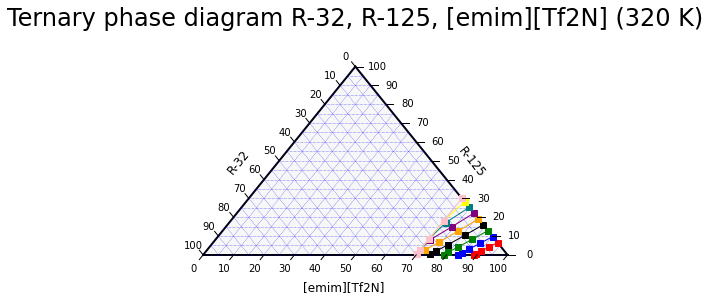

In [10]:
import ternary

scale = 100
figure, tax = ternary.figure(scale=scale)

# Draw Boundary and Gridlines
tax.boundary(linewidth=2.0)
tax.gridlines(color="blue", multiple=5)

# Set Axis labels and Title
fontsize = 12
offset = 0.14
tax.set_title("Ternary phase diagram R-32, R-125, [emim][Tf2N] (320 K)\n", fontsize=24)
tax.left_axis_label("R-32", fontsize=fontsize, offset=offset)
tax.right_axis_label("R-125", fontsize=fontsize, offset=offset)
tax.bottom_axis_label("[emim][Tf2N]", fontsize=fontsize, offset=offset)

color_options = ['red','blue','green','black','orange','purple','teal','yellow','pink']

for i in range(len(P)):
    color = color_options[i]
    i = i + 1
    print("points",i,"are:",points_x[5*i-5:5*i])
    tax.plot(points_x[5*i-5:5*i], marker='s', linewidth=1., color=color, linestyle="-")

tax.ticks(axis='lbr', multiple=10, linewidth=1, offset=0.025)
tax.get_axes().axis('off')
tax.clear_matplotlib_ticks()
tax.show()
# tax.savefig('emimTf2N_ternary_300K.pdf')